# Running TARDIS with a custom packet source

In [1]:
import numpy as np
from tardis import constants as const
from astropy import units as u
from tardis.montecarlo.packet_source import BasePacketSource
from tardis import run_tardis
import matplotlib.pyplot as plt
from tardis.io.atom_data import download_atom_data

/usr/share/miniconda/envs/tardis/lib/python3.7/importlib/_bootstrap.py:219: QAWarning: pyne.data is not yet QA compliant.
  return f(*args, **kwds)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/traitlets/traitlets.py:3036: FutureWarning: --rc={'figure.dpi': 96} for dict-traits is deprecated in traitlets 5.0. You can pass --rc <key=value> ... multiple times to add items to a dict.
  FutureWarning,
 (warnings.py:110)


In [2]:
download_atom_data('kurucz_cd23_chianti_H_He')

[tardis.io.atom_data.atom_web_download][INFO   ]  Downloading atomic data from https://media.githubusercontent.com/media/tardis-sn/tardis-refdata/master/atom_data/kurucz_cd23_chianti_H_He.h5 to /home/runner/Downloads/tardis-data/kurucz_cd23_chianti_H_He.h5 (atom_web_download.py:49)


Custom packet source class that is derived from BasePacketSource. The method create_packets (which returns ```nus, mus, energies```) has to be defined.

In [3]:
class TruncBlackbodySource(BasePacketSource):
    """
        Custom inner boundary source class to replace the Blackbody source
        with a truncated Blackbody source.
    """
    
    def __init__(self, seed, truncation_wavelength):
        super().__init__(seed)
        self.rng = np.random.default_rng(seed=seed)
        self.truncation_wavelength = truncation_wavelength
    
    def create_packets(self, T, no_of_packets, rng,
                       drawing_sample_size=None):
        """
        Packet source that generates a truncated Blackbody source.
        
        Parameters
        ----------
        T : float
            Blackbody temperature
        no_of_packets : int
            number of packets to be created
        truncation_wavelength : float
            truncation wavelength in Angstrom. 
            Only wavelengths higher than the truncation wavelength
            will be sampled.
        """

        # Use mus and energies from normal blackbody source.
        mus = self.create_zero_limb_darkening_packet_mus(no_of_packets, self.rng)
        energies = self.create_uniform_packet_energies(no_of_packets, self.rng)

        # If not specified, draw 2 times as many packets and reject any beyond no_of_packets.
        if drawing_sample_size is None:
            drawing_sample_size = 2 * no_of_packets

        # Blackbody will be truncated below truncation_wavelength / above truncation_frequency.
        truncation_frequency = u.Quantity(self.truncation_wavelength, u.Angstrom).to(
                                          u.Hz, equivalencies=u.spectral()).value
        
        # Draw nus from blackbody distribution and reject based on truncation_frequency.
        # If more nus.shape[0] > no_of_packets use only the first no_of_packets.
        nus = self.create_blackbody_packet_nus(T, drawing_sample_size, self.rng)
        nus = nus[nus<truncation_frequency][:no_of_packets]
        
        
        # Only required if the truncation wavelength is too big compared to the maximum 
        # of the blackbody distribution. Keep sampling until nus.shape[0] > no_of_packets.
        while nus.shape[0] < no_of_packets:
            additional_nus = self.create_blackbody_packet_nus(
                T, drawing_sample_size, self.rng
            )
            mask = additional_nus < truncation_frequency
            additional_nus = additional_nus[mask][:no_of_packets]
            nus = np.hstack([nus, additional_nus])[:no_of_packets]
            
        return nus, mus, energies

In [4]:
packet_source = TruncBlackbodySource(
    53253, truncation_wavelength=2000
)

In [5]:
mdl = run_tardis('tardis_example.yml',
                 packet_source=packet_source)
mdl_norm = run_tardis('tardis_example.yml')

[tardis.plasma.standard_plasmas][INFO   ]  Reading Atomic Data from kurucz_cd23_chianti_H_He.h5 (standard_plasmas.py:87)


[tardis.io.atom_data.util][INFO   ]  Atom Data kurucz_cd23_chianti_H_He.h5 not found in local path. Exists in TARDIS Data repo /home/runner/Downloads/tardis-data/kurucz_cd23_chianti_H_He.h5 (util.py:35)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3418: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)
 (warnings.py:110)


[tardis.io.atom_data.base][INFO   ]  Read Atom Data with UUID=6f7b09e887a311e7a06b246e96350010 and MD5=864f1753714343c41f99cb065710cace. (base.py:172)


[tardis.io.atom_data.base][INFO   ]  Non provided atomic data: synpp_refs, photoionization_data (base.py:178)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
 (warnings.py:110)


[tardis.simulation.base][INFO   ]  Starting iteration 1/20 (base.py:326)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/base.py:178: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/interaction.py", line 21:
@njit(**njit_dict)
def thomson_scatter(r_packet, time_explosion):
^

  r_packet, numba_model, numba_plasma, estimators, vpacket_collection
 (warnings.py:110)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/base.py:178: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/interaction.py", line 56:
@njit(**njit_dict)
def line_scatter(r_packet, time_explosion, line_interaction_type, numba_plasma):
^

  r_packet, numba_model, numba_plasma, estimators, vpacket_collection
 (warnings.py:110)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/base.py:178: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/r_packet.py", line 344:
@njit(**njit_dict)
def trace_packet(r_packet, numba_model, numba_plasma, estimators):
^

  r_packet, numba_model, numba_plasma, estimators, vpacket_collection
 (warnings.py:110)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/base.py:178: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/r_packet.py", line 500:
@njit(**njit_dict)
def move_r_packet(r_packet, distance, time_explosion, numba_estimator):
^

  r_packet, numba_model, numba_plasma, estimators, vpacket_collection
 (warnings.py:110)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/base.py:178: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/r_packet.py", line 573:
@njit(**njit_dict)
def move_packet_across_shell_boundary(packet, delta_shell, no_of_shells):
^

  r_packet, numba_model, numba_plasma, estimators, vpacket_collection
 (warnings.py:110)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/base.py:178: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/vpacket.py", line 193:
@njit(**njit_dict)
def trace_vpacket_volley(
^

  r_packet, numba_model, numba_plasma, estimators, vpacket_collection
 (warnings.py:110)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/base.py:178: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/interaction.py", line 87:
@njit(**njit_dict)
def line_emission(r_packet, emission_line_id, time_explosion, numba_plasma):
^

  r_packet, numba_model, numba_plasma, estimators, vpacket_collection
 (warnings.py:110)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/base.py:178: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/macro_atom.py", line 22:
@njit(**njit_dict)
def macro_atom(r_packet, numba_plasma):
^

  r_packet, numba_model, numba_plasma, estimators, vpacket_collection
 (warnings.py:110)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/base.py:178: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/r_packet.py", line 131:
@njit(**njit_dict)
def calculate_distance_line(
^

  r_packet, numba_model, numba_plasma, estimators, vpacket_collection
 (warnings.py:110)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/base.py:178: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/r_packet.py", line 207:
@njit(**njit_dict)
def calculate_distance_electron(electron_density, tau_event):
^

  r_packet, numba_model, numba_plasma, estimators, vpacket_collection
 (warnings.py:110)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/base.py:178: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/r_packet.py", line 233:
@njit(**njit_dict)
def get_doppler_factor(r, mu, time_explosion):
^

  r_packet, numba_model, numba_plasma, estimators, vpacket_collection
 (warnings.py:110)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/base.py:178: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/r_packet.py", line 254:
@njit(**njit_dict)
def get_inverse_doppler_factor(r, mu, time_explosion):
^

  r_packet, numba_model, numba_plasma, estimators, vpacket_collection
 (warnings.py:110)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/base.py:178: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/r_packet.py", line 285:
@njit(**njit_dict)
def get_random_mu():
^

  r_packet, numba_model, numba_plasma, estimators, vpacket_collection
 (warnings.py:110)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/base.py:178: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/r_packet.py", line 290:
@njit(**njit_dict)
def update_line_estimators(
^

  r_packet, numba_model, numba_plasma, estimators, vpacket_collection
 (warnings.py:110)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/base.py:178: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/r_packet.py", line 548:
@njit(**njit_dict)
def set_estimators(r_packet, distance, numba_estimator, comov_nu, comov_energy):
^

  r_packet, numba_model, numba_plasma, estimators, vpacket_collection
 (warnings.py:110)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/base.py:178: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/r_packet.py", line 561:
@njit(**njit_dict)
def set_estimators_full_relativity(
^

  r_packet, numba_model, numba_plasma, estimators, vpacket_collection
 (warnings.py:110)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/base.py:178: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/r_packet.py", line 601:
@njit(**njit_dict)
def angle_aberration_CMF_to_LF(r_packet, time_explosion, mu):
^

  r_packet, numba_model, numba_plasma, estimators, vpacket_collection
 (warnings.py:110)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/base.py:178: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/r_packet.py", line 612:
@njit(**njit_dict)
def angle_aberration_LF_to_CMF(r_packet, time_explosion, mu):
^

  r_packet, numba_model, numba_plasma, estimators, vpacket_collection
 (warnings.py:110)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/base.py:178: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/r_packet.py", line 625:
@njit(**njit_dict)
def test_for_close_line(r_packet, line_id, nu_line, numba_plasma):
^

  r_packet, numba_model, numba_plasma, estimators, vpacket_collection
 (warnings.py:110)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/base.py:178: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/vpacket.py", line 138:
@njit(**njit_dict)
def trace_vpacket(v_packet, numba_model, numba_plasma):
^

  r_packet, numba_model, numba_plasma, estimators, vpacket_collection
 (warnings.py:110)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/base.py:178: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/r_packet.py", line 182:
@njit(**njit_dict)
def calculate_distance_line_full_relativity(
^

  r_packet, numba_model, numba_plasma, estimators, vpacket_collection
 (warnings.py:110)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/base.py:178: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/r_packet.py", line 244:
@njit(**njit_dict)
def get_doppler_factor_partial_relativity(mu, beta):
^

  r_packet, numba_model, numba_plasma, estimators, vpacket_collection
 (warnings.py:110)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/base.py:178: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/r_packet.py", line 249:
@njit(**njit_dict)
def get_doppler_factor_full_relativity(mu, beta):
^

  r_packet, numba_model, numba_plasma, estimators, vpacket_collection
 (warnings.py:110)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/base.py:178: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/r_packet.py", line 275:
@njit(**njit_dict)
def get_inverse_doppler_factor_partial_relativity(mu, beta):
^

  r_packet, numba_model, numba_plasma, estimators, vpacket_collection
 (warnings.py:110)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/base.py:178: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/r_packet.py", line 280:
@njit(**njit_dict)
def get_inverse_doppler_factor_full_relativity(mu, beta):
^

  r_packet, numba_model, numba_plasma, estimators, vpacket_collection
 (warnings.py:110)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/base.py:178: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/r_packet.py", line 328:
@njit(**njit_dict)
def calc_packet_energy_full_relativity(r_packet):
^

  r_packet, numba_model, numba_plasma, estimators, vpacket_collection
 (warnings.py:110)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/base.py:178: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/r_packet.py", line 334:
@njit(**njit_dict)
def calc_packet_energy(r_packet, distance_trace, time_explosion):
^

  r_packet, numba_model, numba_plasma, estimators, vpacket_collection
 (warnings.py:110)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/base.py:178: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/r_packet.py", line 573:
@njit(**njit_dict)
def move_packet_across_shell_boundary(packet, delta_shell, no_of_shells):
^

  r_packet, numba_model, numba_plasma, estimators, vpacket_collection
 (warnings.py:110)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/base.py:178: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/vpacket.py", line 62:
@njit(**njit_dict)
def trace_vpacket_within_shell(v_packet, numba_model, numba_plasma):
^

  r_packet, numba_model, numba_plasma, estimators, vpacket_collection
 (warnings.py:110)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/base.py:178: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/r_packet.py", line 131:
@njit(**njit_dict)
def calculate_distance_line(
^

  r_packet, numba_model, numba_plasma, estimators, vpacket_collection
 (warnings.py:110)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/base.py:178: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/r_packet.py", line 219:
@njit(**njit_dict)
def calculate_tau_electron(electron_density, distance):
^

  r_packet, numba_model, numba_plasma, estimators, vpacket_collection
 (warnings.py:110)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/base.py:178: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/r_packet.py", line 86:
@njit(**njit_dict)
def calculate_distance_boundary(r, mu, r_inner, r_outer):
^

  r_packet, numba_model, numba_plasma, estimators, vpacket_collection
 (warnings.py:110)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/base.py:178: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/tardis_sn-3.0.dev1-py3.7-linux-x86_64.egg/tardis/montecarlo/montecarlo_numba/r_packet.py", line 182:
@njit(**njit_dict)
def calculate_distance_line_full_relativity(
^

  r_packet, numba_model, numba_plasma, estimators, vpacket_collection
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 8.03511e+42 erg / s Luminosity absorbed = 2.57323e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:450)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad   next_t_rad         w    next_w
	Shell                                              
	0      9926.501965  9413.138423  0.400392  0.675086
	5      9852.611678  9735.709498  0.211205  0.240419
	10     9779.813302  9621.763697  0.142695  0.144937
	15     9708.082813  9348.762000  0.104556  0.109191

 (base.py:436)


[tardis.simulation.base][INFO   ]  t_inner 9933.952 K -- next t_inner 11405.929 K (base.py:439)


[tardis.simulation.base][INFO   ]  Starting iteration 2/20 (base.py:326)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.38616e+43 erg / s Luminosity absorbed = 4.56961e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:450)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9413.138423   9968.230021  0.675086  0.944413
	5      9735.709498  10249.819824  0.240419  0.340455
	10     9621.763697  10241.727659  0.144937  0.196401
	15     9348.762000   9967.797457  0.109191  0.145944

 (base.py:436)


[tardis.simulation.base][INFO   ]  t_inner 11405.929 K -- next t_inner 9970.755 K (base.py:439)


[tardis.simulation.base][INFO   ]  Starting iteration 3/20 (base.py:326)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 8.22514e+42 erg / s Luminosity absorbed = 2.54582e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:450)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad   next_t_rad         w    next_w
	Shell                                               
	0       9968.230021  9352.975543  0.944413  0.703667
	5      10249.819824  9640.405246  0.340455  0.252929
	10     10241.727659  9570.899493  0.196401  0.153417
	15      9967.797457  9343.381992  0.145944  0.111889

 (base.py:436)


[tardis.simulation.base][INFO   ]  t_inner 9970.755 K -- next t_inner 11315.166 K (base.py:439)


[tardis.simulation.base][INFO   ]  Starting iteration 4/20 (base.py:326)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.34673e+43 erg / s Luminosity absorbed = 4.38292e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:450)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9352.975543   9895.927775  0.703667  0.939561
	5      9640.405246  10131.973029  0.252929  0.347876
	10     9570.899493  10080.623924  0.153417  0.203897
	15     9343.381992   9866.950689  0.111889  0.148152

 (base.py:436)


[tardis.simulation.base][INFO   ]  t_inner 11315.166 K -- next t_inner 10035.185 K (base.py:439)


[tardis.simulation.base][INFO   ]  Starting iteration 5/20 (base.py:326)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 8.36964e+42 erg / s Luminosity absorbed = 2.68036e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:450)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad   next_t_rad         w    next_w
	Shell                                               
	0       9895.927775  9349.055054  0.939561  0.721569
	5      10131.973029  9663.682479  0.347876  0.257827
	10     10080.623924  9589.858001  0.203897  0.153798
	15      9866.950689  9346.844370  0.148152  0.113489

 (base.py:436)


[tardis.simulation.base][INFO   ]  t_inner 10035.185 K -- next t_inner 11289.548 K (base.py:439)


[tardis.simulation.base][INFO   ]  Starting iteration 6/20 (base.py:326)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.32852e+43 erg / s Luminosity absorbed = 4.40000e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:450)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9349.055054   9922.948385  0.721569  0.917613
	5      9663.682479  10180.442078  0.257827  0.342036
	10     9589.858001  10148.019255  0.153798  0.196131
	15     9346.844370   9947.832370  0.113489  0.141396

 (base.py:436)


[tardis.simulation.base][INFO   ]  t_inner 11289.548 K -- next t_inner 10080.862 K (base.py:439)


[tardis.simulation.base][INFO   ]  Starting iteration 7/20 (base.py:326)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 8.55802e+42 erg / s Luminosity absorbed = 2.69965e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:450)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad   next_t_rad         w    next_w
	Shell                                               
	0       9922.948385  9399.594153  0.917613  0.714793
	5      10180.442078  9682.945262  0.342036  0.260107
	10     10148.019255  9605.003449  0.196131  0.155591
	15      9947.832370  9328.763174  0.141396  0.116489

 (base.py:436)


[tardis.simulation.base][INFO   ]  t_inner 10080.862 K -- next t_inner 11215.424 K (base.py:439)


[tardis.simulation.base][INFO   ]  Starting iteration 8/20 (base.py:326)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.29516e+43 erg / s Luminosity absorbed = 4.27222e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:450)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9399.594153   9889.442118  0.714793  0.905099
	5      9682.945262  10063.124106  0.260107  0.348708
	10     9605.003449  10077.510315  0.155591  0.198014
	15     9328.763174   9883.445863  0.116489  0.141124

 (base.py:436)


[tardis.simulation.base][INFO   ]  t_inner 11215.424 K -- next t_inner 10142.822 K (base.py:439)


[tardis.simulation.base][INFO   ]  Starting iteration 9/20 (base.py:326)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 8.73956e+42 erg / s Luminosity absorbed = 2.79275e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:450)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad   next_t_rad         w    next_w
	Shell                                               
	0       9889.442118  9430.305877  0.905099  0.727552
	5      10063.124106  9678.150801  0.348708  0.266011
	10     10077.510315  9624.075991  0.198014  0.157349
	15      9883.445863  9420.635962  0.141124  0.114521

 (base.py:436)


[tardis.simulation.base][INFO   ]  t_inner 10142.822 K -- next t_inner 11166.543 K (base.py:439)


[tardis.simulation.base][INFO   ]  Starting iteration 10/20 (base.py:326)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.27790e+43 erg / s Luminosity absorbed = 4.15337e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:450)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9430.305877   9869.494682  0.727552  0.898558
	5      9678.150801  10120.018962  0.266011  0.332509
	10     9624.075991  10141.793848  0.157349  0.189287
	15     9420.635962   9871.856574  0.114521  0.139655

 (base.py:436)


[tardis.simulation.base][INFO   ]  t_inner 11166.543 K -- next t_inner 10166.590 K (base.py:439)


[tardis.simulation.base][INFO   ]  Starting iteration 11/20 (base.py:326)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 8.84222e+42 erg / s Luminosity absorbed = 2.80066e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:450)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad   next_t_rad         w    next_w
	Shell                                               
	0       9869.494682  9446.987155  0.898558  0.733896
	5      10120.018962  9666.414290  0.332509  0.270056
	10     10141.793848  9555.934436  0.189287  0.163842
	15      9871.856574  9352.837518  0.139655  0.118963

 (base.py:436)


[tardis.simulation.base][INFO   ]  t_inner 10166.590 K -- next t_inner 11127.546 K (base.py:439)


[tardis.simulation.base][INFO   ]  Starting iteration 12/20 (base.py:326)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.25013e+43 erg / s Luminosity absorbed = 4.18782e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:450)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9446.987155   9883.108451  0.733896  0.892881
	5      9666.414290  10149.038463  0.270056  0.324678
	10     9555.934436  10127.411704  0.163842  0.185648
	15     9352.837518   9854.392138  0.118963  0.137671

 (base.py:436)


[tardis.simulation.base][INFO   ]  t_inner 11127.546 K -- next t_inner 10242.994 K (base.py:439)


[tardis.simulation.base][INFO   ]  Starting iteration 13/20 (base.py:326)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 9.14496e+42 erg / s Luminosity absorbed = 2.85108e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:450)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad   next_t_rad         w    next_w
	Shell                                               
	0       9883.108451  9444.824242  0.892881  0.753960
	5      10149.038463  9808.182625  0.324678  0.264766
	10     10127.411704  9695.434831  0.185648  0.160099
	15      9854.392138  9496.727223  0.137671  0.117310

 (base.py:436)


[tardis.simulation.base][INFO   ]  t_inner 10242.994 K -- next t_inner 11024.037 K (base.py:439)


[tardis.simulation.base][INFO   ]  Starting iteration 14/20 (base.py:326)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.21264e+43 erg / s Luminosity absorbed = 3.95823e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:450)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9444.824242   9825.371483  0.753960  0.868042
	5      9808.182625  10090.790472  0.264766  0.317917
	10     9695.434831  10055.564675  0.160099  0.185605
	15     9496.727223   9815.942897  0.117310  0.136242

 (base.py:436)


[tardis.simulation.base][INFO   ]  t_inner 11024.037 K -- next t_inner 10303.387 K (base.py:439)


[tardis.simulation.base][INFO   ]  Starting iteration 15/20 (base.py:326)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 9.24937e+42 erg / s Luminosity absorbed = 3.02670e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:450)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad   next_t_rad         w    next_w
	Shell                                               
	0       9825.371483  9467.434936  0.868042  0.765604
	5      10090.790472  9757.533220  0.317917  0.274276
	10     10055.564675  9656.380373  0.185605  0.166244
	15      9815.942897  9410.293278  0.136242  0.122308

 (base.py:436)


[tardis.simulation.base][INFO   ]  t_inner 10303.387 K -- next t_inner 11026.268 K (base.py:439)


[tardis.simulation.base][INFO   ]  Starting iteration 16/20 (base.py:326)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.21075e+43 erg / s Luminosity absorbed = 3.98808e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:450)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9467.434936   9794.163437  0.765604  0.883732
	5      9757.533220  10029.540524  0.274276  0.323268
	10     9656.380373   9978.692982  0.166244  0.191716
	15     9410.293278   9796.986028  0.122308  0.135979

 (base.py:436)


[tardis.simulation.base][INFO   ]  t_inner 11026.268 K -- next t_inner 10313.496 K (base.py:439)


[tardis.simulation.base][INFO   ]  Starting iteration 17/20 (base.py:326)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 9.32414e+42 erg / s Luminosity absorbed = 3.00213e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:450)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad   next_t_rad         w    next_w
	Shell                                               
	0       9794.163437  9492.979151  0.883732  0.760939
	5      10029.540524  9776.892211  0.323268  0.274139
	10      9978.692982  9711.640273  0.191716  0.162022
	15      9796.986028  9559.457346  0.135979  0.116328

 (base.py:436)


[tardis.simulation.base][INFO   ]  t_inner 10313.496 K -- next t_inner 10992.745 K (base.py:439)


[tardis.simulation.base][INFO   ]  Starting iteration 18/20 (base.py:326)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.20280e+43 erg / s Luminosity absorbed = 3.87568e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:450)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9492.979151   9803.376069  0.760939  0.860173
	5      9776.892211  10005.414968  0.274139  0.325750
	10     9711.640273  10052.112445  0.162022  0.184829
	15     9559.457346   9787.013349  0.116328  0.136303

 (base.py:436)


[tardis.simulation.base][INFO   ]  t_inner 10992.745 K -- next t_inner 10316.061 K (base.py:439)


[tardis.simulation.base][INFO   ]  Starting iteration 19/20 (base.py:326)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 9.33198e+42 erg / s Luminosity absorbed = 3.00717e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:450)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad   next_t_rad         w    next_w
	Shell                                               
	0       9803.376069  9488.891720  0.860173  0.764424
	5      10005.414968  9760.387430  0.325750  0.276406
	10     10052.112445  9685.754561  0.184829  0.164643
	15      9787.013349  9509.828700  0.136303  0.118369

 (base.py:436)


[tardis.simulation.base][INFO   ]  t_inner 10316.061 K -- next t_inner 10990.861 K (base.py:439)


[tardis.simulation.base][INFO   ]  Starting iteration 20/20 (base.py:326)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.19472e+43 erg / s Luminosity absorbed = 3.94089e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:450)


[tardis.simulation.base][INFO   ]  Simulation finished in 20 iterations and took 47.55 s (base.py:384)


[tardis.plasma.standard_plasmas][INFO   ]  Reading Atomic Data from kurucz_cd23_chianti_H_He.h5 (standard_plasmas.py:87)


[tardis.io.atom_data.util][INFO   ]  Atom Data kurucz_cd23_chianti_H_He.h5 not found in local path. Exists in TARDIS Data repo /home/runner/Downloads/tardis-data/kurucz_cd23_chianti_H_He.h5 (util.py:35)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3418: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)
 (warnings.py:110)


[tardis.io.atom_data.base][INFO   ]  Read Atom Data with UUID=6f7b09e887a311e7a06b246e96350010 and MD5=864f1753714343c41f99cb065710cace. (base.py:172)


[tardis.io.atom_data.base][INFO   ]  Non provided atomic data: synpp_refs, photoionization_data (base.py:178)


[tardis.simulation.base][INFO   ]  Starting iteration 1/20 (base.py:326)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 7.94275e+42 erg / s Luminosity absorbed = 2.65805e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:450)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9926.501965  10134.733717  0.400392  0.508204
	5      9852.611678  10222.890845  0.211205  0.197026
	10     9779.813302  10144.463169  0.142695  0.117179
	15     9708.082813   9873.477846  0.104556  0.086941

 (base.py:436)


[tardis.simulation.base][INFO   ]  t_inner 9933.952 K -- next t_inner 11472.055 K (base.py:439)


[tardis.simulation.base][INFO   ]  Starting iteration 2/20 (base.py:326)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.40815e+43 erg / s Luminosity absorbed = 4.77001e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:450)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      10134.733717  11468.021903  0.508204  0.548671
	5      10222.890845  11499.835340  0.197026  0.221374
	10     10144.463169  11306.370330  0.117179  0.136291
	15      9873.477846  10953.828130  0.086941  0.102617

 (base.py:436)


[tardis.simulation.base][INFO   ]  t_inner 11472.055 K -- next t_inner 9949.978 K (base.py:439)


[tardis.simulation.base][INFO   ]  Starting iteration 3/20 (base.py:326)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 8.12624e+42 erg / s Luminosity absorbed = 2.54722e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:450)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11468.021903  10497.008397  0.548671  0.442299
	5      11499.835340  10799.075913  0.221374  0.164288
	10     11306.370330  10623.433274  0.136291  0.101820
	15     10953.828130  10226.187071  0.102617  0.077629

 (base.py:436)


[tardis.simulation.base][INFO   ]  t_inner 9949.978 K -- next t_inner 11360.097 K (base.py:439)


[tardis.simulation.base][INFO   ]  Starting iteration 4/20 (base.py:326)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.36297e+43 erg / s Luminosity absorbed = 4.49721e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:450)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      10497.008397  11615.344313  0.442299  0.497714
	5      10799.075913  11729.411389  0.164288  0.199205
	10     10623.433274  11517.190317  0.101820  0.123849
	15     10226.187071  11103.373456  0.077629  0.093930

 (base.py:436)


[tardis.simulation.base][INFO   ]  t_inner 11360.097 K -- next t_inner 10014.843 K (base.py:439)


[tardis.simulation.base][INFO   ]  Starting iteration 5/20 (base.py:326)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 8.27895e+42 erg / s Luminosity absorbed = 2.66933e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:450)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11615.344313  10549.514128  0.497714  0.443441
	5      11729.411389  10919.073481  0.199205  0.162199
	10     11517.190317  10697.303300  0.123849  0.101289
	15     11103.373456  10379.863073  0.093930  0.075372

 (base.py:436)


[tardis.simulation.base][INFO   ]  t_inner 10014.843 K -- next t_inner 11328.210 K (base.py:439)


[tardis.simulation.base][INFO   ]  Starting iteration 6/20 (base.py:326)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.34741e+43 erg / s Luminosity absorbed = 4.44727e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:450)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      10549.514128  11567.208184  0.443441  0.504178
	5      10919.073481  11653.124121  0.162199  0.203042
	10     10697.303300  11425.955010  0.101289  0.125249
	15     10379.863073  11082.155938  0.075372  0.094028

 (base.py:436)


[tardis.simulation.base][INFO   ]  t_inner 11328.210 K -- next t_inner 10044.200 K (base.py:439)


[tardis.simulation.base][INFO   ]  Starting iteration 7/20 (base.py:326)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 8.39001e+42 erg / s Luminosity absorbed = 2.69230e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:450)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11567.208184  10569.747403  0.504178  0.442290
	5      11653.124121  11099.194259  0.203042  0.153253
	10     11425.955010  10809.397890  0.125249  0.097256
	15     11082.155938  10454.841299  0.094028  0.073809

 (base.py:436)


[tardis.simulation.base][INFO   ]  t_inner 10044.200 K -- next t_inner 11285.966 K (base.py:439)


[tardis.simulation.base][INFO   ]  Starting iteration 8/20 (base.py:326)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.33305e+43 erg / s Luminosity absorbed = 4.33011e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:450)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      10569.747403  11547.678162  0.442290  0.500345
	5      11099.194259  11669.739508  0.153253  0.198338
	10     10809.397890  11493.569590  0.097256  0.121915
	15     10454.841299  11083.769586  0.073809  0.092834

 (base.py:436)


[tardis.simulation.base][INFO   ]  t_inner 11285.966 K -- next t_inner 10060.511 K (base.py:439)


[tardis.simulation.base][INFO   ]  Starting iteration 9/20 (base.py:326)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 8.44283e+42 erg / s Luminosity absorbed = 2.70894e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:450)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11547.678162  10635.099217  0.500345  0.439520
	5      11669.739508  11035.731464  0.198338  0.158320
	10     11493.569590  10717.471486  0.121915  0.101642
	15     11083.769586  10404.049299  0.092834  0.075794

 (base.py:436)


[tardis.simulation.base][INFO   ]  t_inner 10060.511 K -- next t_inner 11268.877 K (base.py:439)


[tardis.simulation.base][INFO   ]  Starting iteration 10/20 (base.py:326)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.32925e+43 erg / s Luminosity absorbed = 4.25943e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:450)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      10635.099217  11500.557678  0.439520  0.506895
	5      11035.731464  11715.267406  0.158320  0.196690
	10     10717.471486  11451.270656  0.101642  0.123243
	15     10404.049299  11094.423438  0.075794  0.092243

 (base.py:436)


[tardis.simulation.base][INFO   ]  t_inner 11268.877 K -- next t_inner 10059.624 K (base.py:439)


[tardis.simulation.base][INFO   ]  Starting iteration 11/20 (base.py:326)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 8.49497e+42 erg / s Luminosity absorbed = 2.65616e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:450)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11500.557678  10570.856509  0.506895  0.445926
	5      11715.267406  10957.336276  0.196690  0.162837
	10     11451.270656  10916.410391  0.123243  0.096229
	15     11094.423438  10441.053929  0.092243  0.075026

 (base.py:436)


[tardis.simulation.base][INFO   ]  t_inner 10059.624 K -- next t_inner 11233.248 K (base.py:439)


[tardis.simulation.base][INFO   ]  Starting iteration 12/20 (base.py:326)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.30417e+43 erg / s Luminosity absorbed = 4.28820e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:450)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      10570.856509  11533.554419  0.445926  0.494814
	5      10957.336276  11764.967895  0.162837  0.189464
	10     10916.410391  11444.191999  0.096229  0.121150
	15     10441.053929  11084.736033  0.075026  0.090825

 (base.py:436)


[tardis.simulation.base][INFO   ]  t_inner 11233.248 K -- next t_inner 10123.784 K (base.py:439)


[tardis.simulation.base][INFO   ]  Starting iteration 13/20 (base.py:326)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 8.69244e+42 erg / s Luminosity absorbed = 2.74548e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:450)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11533.554419  10680.784661  0.494814  0.439281
	5      11764.967895  10887.379428  0.189464  0.170137
	10     11444.191999  10825.792025  0.121150  0.100780
	15     11084.736033  10402.120228  0.090825  0.077634

 (base.py:436)


[tardis.simulation.base][INFO   ]  t_inner 10123.784 K -- next t_inner 11175.750 K (base.py:439)


[tardis.simulation.base][INFO   ]  Starting iteration 14/20 (base.py:326)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.28354e+43 erg / s Luminosity absorbed = 4.15095e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:450)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      10680.784661  11437.188130  0.439281  0.496749
	5      10887.379428  11571.106856  0.170137  0.196714
	10     10825.792025  11378.137918  0.100780  0.120954
	15     10402.120228  10957.211814  0.077634  0.092896

 (base.py:436)


[tardis.simulation.base][INFO   ]  t_inner 11175.750 K -- next t_inner 10152.603 K (base.py:439)


[tardis.simulation.base][INFO   ]  Starting iteration 15/20 (base.py:326)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 8.75331e+42 erg / s Luminosity absorbed = 2.81319e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:450)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11437.188130  10637.774893  0.496749  0.452668
	5      11571.106856  11002.647927  0.196714  0.166197
	10     11378.137918  10832.042108  0.120954  0.101284
	15     10957.211814  10350.602742  0.092896  0.079468

 (base.py:436)


[tardis.simulation.base][INFO   ]  t_inner 10152.603 K -- next t_inner 11168.529 K (base.py:439)


[tardis.simulation.base][INFO   ]  Starting iteration 16/20 (base.py:326)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.27820e+43 erg / s Luminosity absorbed = 4.15606e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:450)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      10637.774893  11420.979987  0.452668  0.499488
	5      11002.647927  11711.923994  0.166197  0.186857
	10     10832.042108  11421.346118  0.101284  0.119700
	15     10350.602742  11076.434180  0.079468  0.089402

 (base.py:436)


[tardis.simulation.base][INFO   ]  t_inner 11168.529 K -- next t_inner 10167.208 K (base.py:439)


[tardis.simulation.base][INFO   ]  Starting iteration 17/20 (base.py:326)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 8.81647e+42 erg / s Luminosity absorbed = 2.81681e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:450)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11420.979987  10691.849845  0.499488  0.447482
	5      11711.923994  11042.045712  0.186857  0.164090
	10     11421.346118  10980.886609  0.119700  0.097369
	15     11076.434180  10456.662007  0.089402  0.077097

 (base.py:436)


[tardis.simulation.base][INFO   ]  t_inner 10167.208 K -- next t_inner 11144.459 K (base.py:439)


[tardis.simulation.base][INFO   ]  Starting iteration 18/20 (base.py:326)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.26680e+43 erg / s Luminosity absorbed = 4.12238e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:450)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      10691.849845  11404.686443  0.447482  0.497739
	5      11042.045712  11664.227712  0.164090  0.189070
	10     10980.886609  11444.220669  0.097369  0.117732
	15     10456.662007  11052.698087  0.077097  0.089141

 (base.py:436)


[tardis.simulation.base][INFO   ]  t_inner 11144.459 K -- next t_inner 10190.841 K (base.py:439)


[tardis.simulation.base][INFO   ]  Starting iteration 19/20 (base.py:326)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 8.87081e+42 erg / s Luminosity absorbed = 2.87116e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:450)


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11404.686443  10732.832306  0.497739  0.444436
	5      11664.227712  11084.302807  0.189070  0.162591
	10     11444.220669  10899.736539  0.117732  0.099122
	15     11052.698087  10465.941519  0.089141  0.077378

 (base.py:436)


[tardis.simulation.base][INFO   ]  t_inner 10190.841 K -- next t_inner 11136.097 K (base.py:439)


[tardis.simulation.base][INFO   ]  Starting iteration 20/20 (base.py:326)


[py.warnings         ][WARNING]  /usr/share/miniconda/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


Running post-merge numba montecarlo (with C close lines)!


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.26319e+43 erg / s Luminosity absorbed = 4.10706e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:450)


[tardis.simulation.base][INFO   ]  Simulation finished in 20 iterations and took 35.18 s (base.py:384)


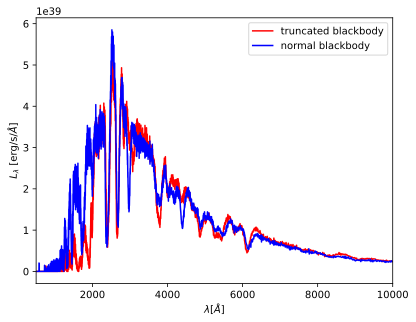

In [6]:
%matplotlib inline
plt.plot(mdl.runner.spectrum_virtual.wavelength,
         mdl.runner.spectrum_virtual.luminosity_density_lambda,
         color='red', label='truncated blackbody')
plt.plot(mdl_norm.runner.spectrum_virtual.wavelength,
         mdl_norm.runner.spectrum_virtual.luminosity_density_lambda,
         color='blue', label='normal blackbody')
plt.xlabel('$\lambda [\AA]$')
plt.ylabel('$L_\lambda$ [erg/s/$\AA$]')
plt.xlim(500, 10000)
plt.legend()